## Logistic Regression

Logistic Regression is a model to predict the probability of a CATEGORICAL target.

The target variable can be:
* Binary: yes or no (0 or 1)
* Multi-nomial: more then 2 options, without hierarchy (i.e.:cat, dog and mouse)
* Ordinal: more then 2 options, with hierarchy (i.e.: rating from 1 to 5)

Don't forget the [DOCS](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). <br>
More on formulas and functions [here](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc).

In [37]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import getpass  # to get the password without showing the input
password = getpass.getpass()

connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

········


Now we want to develop a classification model to predict the status of the customer based on the information available.

In [38]:
# Getting the data:
query = '''SELECT t.type, t.operation, t.amount AS t_amount, t.balance, t.k_symbol, l.amount AS l_amount, l.duration, l.payments, l.status
           FROM loan l
           LEFT JOIN trans t
           ON t.account_id = l.account_id
           WHERE l.status IN ('A', 'B');'''

data = pd.read_sql_query(query, engine)
data

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,,73.8,45821.8,UROK,96396,12,8033.0,B
1,VYDAJ,VYBER,16600.0,45748.0,,96396,12,8033.0,B
2,PRIJEM,VKLAD,3300.0,20100.0,,96396,12,8033.0,B
3,PRIJEM,VKLAD,5800.0,16800.0,,96396,12,8033.0,B
4,PRIJEM,VKLAD,9900.0,11000.0,,96396,12,8033.0,B
...,...,...,...,...,...,...,...,...,...
74359,PRIJEM,PREVOD Z UCTU,47710.0,85215.5,,44628,12,3719.0,A
74360,PRIJEM,,95.5,37505.5,UROK,44628,12,3719.0,A
74361,VYDAJ,VYBER,11200.0,37410.0,,44628,12,3719.0,A
74362,PRIJEM,PREVOD Z UCTU,47710.0,48610.0,,44628,12,3719.0,A


#### Preparation

In [3]:
data.shape, data.dtypes

((74364, 9),
 type          object
 operation     object
 t_amount     float64
 balance      float64
 k_symbol      object
 l_amount       int64
 duration       int64
 payments     float64
 status        object
 dtype: object)

In [4]:
data.isna().sum()

type         0
operation    0
t_amount     0
balance      0
k_symbol     0
l_amount     0
duration     0
payments     0
status       0
dtype: int64

In [5]:
data.describe()

,t_amount,balance,l_amount,duration,payments
count,74364.000000,74364.000000,74364.000000,74364.000000,74364.000000
mean,7832.649125,46022.153061,102745.132645,23.942230,4356.580832
std,11729.040391,25439.948570,74749.275498,12.155783,2205.840892
min,0.000000,-14137.200000,4980.000000,12.000000,319.000000
25%,144.300000,27675.125000,46320.000000,12.000000,2569.000000
50%,3000.000000,40965.150000,86184.000000,24.000000,4051.000000
75%,9868.500000,60098.550000,140400.000000,36.000000,6315.000000
max,87300.000000,193910.000000,464520.000000,60.000000,9736.000000


In [39]:
for col in data.select_dtypes('object'):
    print(data[col].value_counts(), '\n') #unique()

VYDAJ     44075
PRIJEM    27660
VYBER      2629
Name: type, dtype: int64 

VYBER             34667
                  14646
PREVOD NA UCET    11647
VKLAD             10525
PREVOD Z UCTU      2489
VYBER KARTOU        390
Name: operation, dtype: int64 

               35953
UROK           14646
SLUZBY         11306
SIPO            5081
                3018
UVER            2893
POJISTNE        1159
SANKC. UROK      308
Name: k_symbol, dtype: int64 

A    64599
B     9765
Name: status, dtype: int64 



In [7]:
# if you want to filter them out instead of cleaning
# data[(data['k_symbol'] != '') & (data['k_symbol'] != ' ') & (data['operation'] != ' ')] 

#### Data Cleaning

In [40]:
def clean_empty(x):
    return 'UNK' if x == '' or x == ' ' else x

# it's the same as this:
def clean_empty(x):
    if x == '' or x == ' ':
        return 'UNK' 
    else:
        return x
    
# or with lambda
lmd = lambda x: 'UNK' if x == '' or x == ' ' else x

In [41]:
# with regular apply - gets all values row wise OR column wise (axis parameter)
for col in data.select_dtypes('object'):
    data[col] = data[col].apply(clean_empty) # lmb

In [42]:
# with applymap - gets every value (row AND column wise)
data.applymap(clean_empty) # lmb

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,UNK,73.8,45821.8,UROK,96396,12,8033.0,B
1,VYDAJ,VYBER,16600.0,45748.0,UNK,96396,12,8033.0,B
2,PRIJEM,VKLAD,3300.0,20100.0,UNK,96396,12,8033.0,B
3,PRIJEM,VKLAD,5800.0,16800.0,UNK,96396,12,8033.0,B
4,PRIJEM,VKLAD,9900.0,11000.0,UNK,96396,12,8033.0,B
...,...,...,...,...,...,...,...,...,...
74359,PRIJEM,PREVOD Z UCTU,47710.0,85215.5,UNK,44628,12,3719.0,A
74360,PRIJEM,UNK,95.5,37505.5,UROK,44628,12,3719.0,A
74361,VYDAJ,VYBER,11200.0,37410.0,UNK,44628,12,3719.0,A
74362,PRIJEM,PREVOD Z UCTU,47710.0,48610.0,UNK,44628,12,3719.0,A


#### EDA

In [67]:
for col in data.select_dtypes('object'):
    
    # Create a contingency table
    contingency_table = pd.crosstab(data[col], data['status'])

    # Convert the values to percentages
    row_sums = contingency_table.sum(axis=1)
    col_sums = contingency_table.sum(axis=0)
    
    contingency_table["A"] = contingency_table["A"] / contingency_table["A"].sum() * 100
    contingency_table["B"] = contingency_table["B"] / contingency_table["B"].sum() * 100

    # Print the contingency table in percentage
    display(contingency_table)

status,A,B
type,,
PRIJEM,36.472701,41.976446
VYBER,3.427298,4.249872
VYDAJ,60.100002,53.773682


status,A,B
operation,,
PREVOD NA UCET,16.551340,9.779826
PREVOD Z UCTU,3.623895,1.515617
UNK,19.207728,22.918587
VKLAD,13.641078,17.542243
VYBER,46.395455,48.090118
VYBER KARTOU,0.580504,0.153610


status,A,B
k_symbol,,
POJISTNE,1.643988,0.993344
SANKC. UROK,0.080497,2.621608
SIPO,6.927352,6.205837
SLUZBY,15.172061,15.412186
UNK,53.024041,48.315412
UROK,19.207728,22.918587
UVER,3.944334,3.533026


status,A,B
status,,
A,100.0,0.0
B,0.0,100.0


In [61]:
total

status
A    64599
B     9765
dtype: int64

<Axes: xlabel='status', ylabel='balance'>

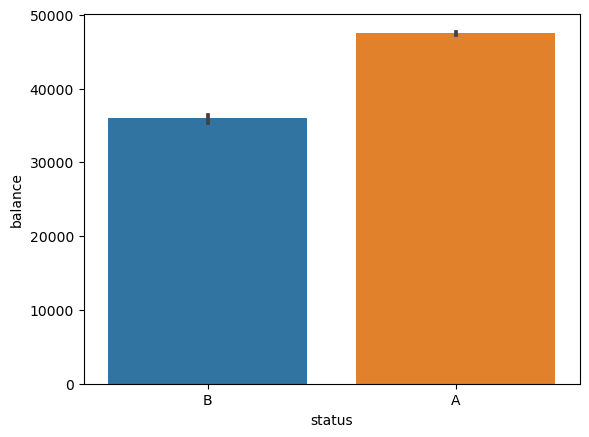

In [78]:
# check relationship between numerical and categorical:
sns.barplot(data=data, x="status", y="balance")

C:\Users\felipe.c.rocha\AppData\Local\Temp\ipykernel_29404\3597185393.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix=data.corr(method='pearson')  # default


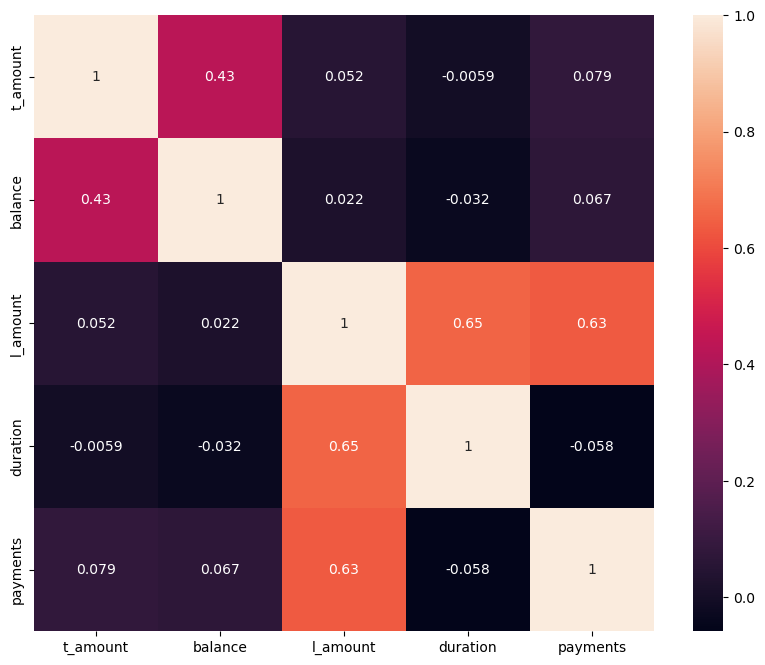

In [43]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

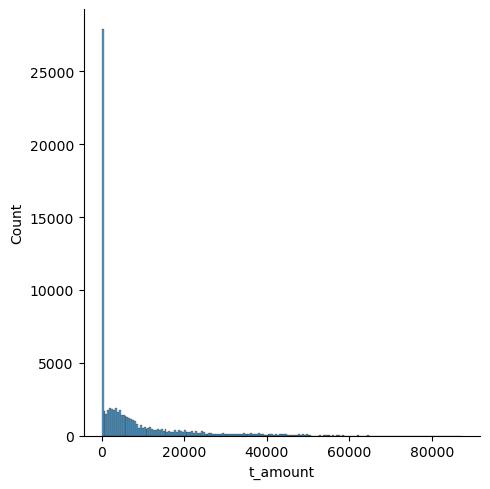

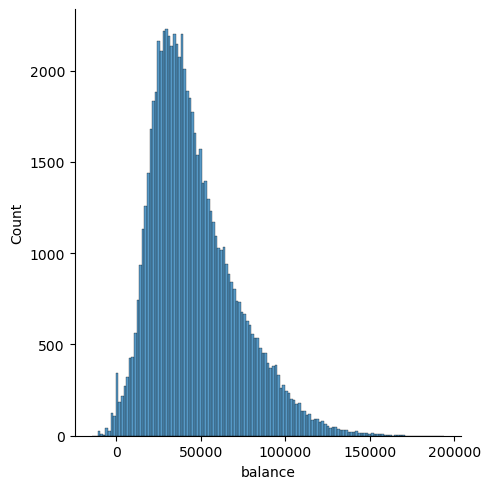

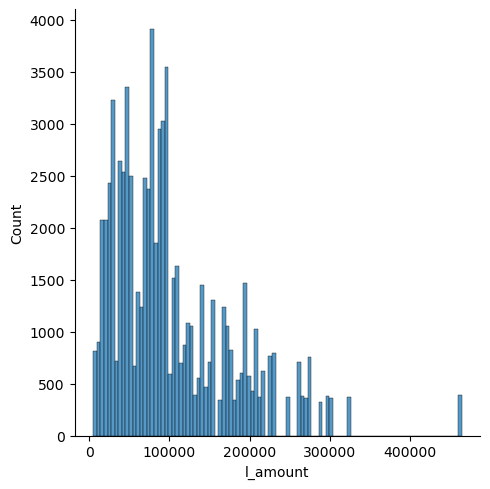

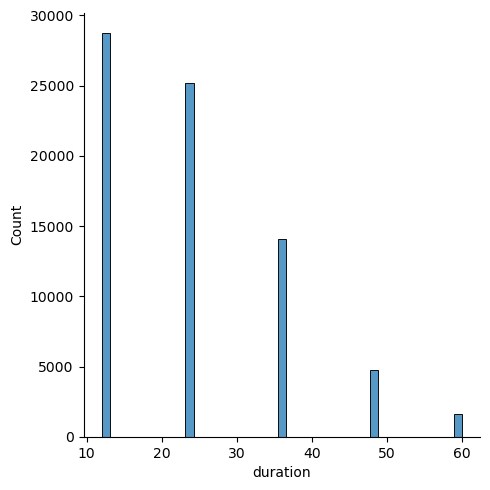

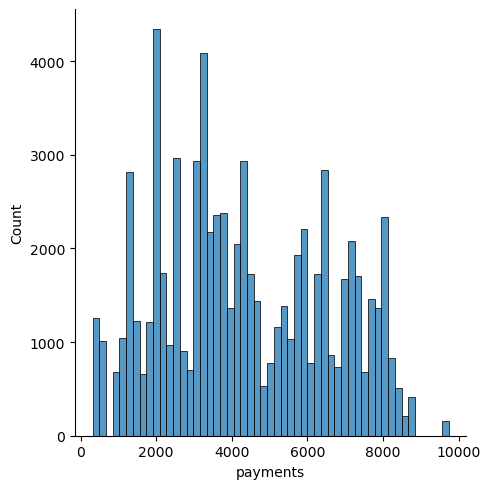

In [14]:
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()

#### Data Processing

In [69]:
y = data['status']
X = data.drop('status', axis=1)

In [70]:
X = pd.get_dummies(X, columns=['type', 'operation', 'k_symbol'])
X

,t_amount,balance,l_amount,duration,payments,type_PRIJEM,type_VYBER,type_VYDAJ,operation_PREVOD NA UCET,operation_PREVOD Z UCTU,...,operation_VKLAD,operation_VYBER,operation_VYBER KARTOU,k_symbol_POJISTNE,k_symbol_SANKC. UROK,k_symbol_SIPO,k_symbol_SLUZBY,k_symbol_UNK,k_symbol_UROK,k_symbol_UVER
0,73.8,45821.8,96396,12,8033.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,16600.0,45748.0,96396,12,8033.0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2,3300.0,20100.0,96396,12,8033.0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,5800.0,16800.0,96396,12,8033.0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,9900.0,11000.0,96396,12,8033.0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74359,47710.0,85215.5,44628,12,3719.0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
74360,95.5,37505.5,44628,12,3719.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
74361,11200.0,37410.0,44628,12,3719.0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
74362,47710.0,48610.0,44628,12,3719.0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [76]:
pd.get_dummies(data).corr()["status_A"].sort_values()

status_B                   -1.000000
l_amount                   -0.259404
payments                   -0.221782
k_symbol_SANKC. UROK       -0.133634
duration                   -0.091150
type_PRIJEM                -0.038460
operation_VKLAD            -0.037800
operation_UNK              -0.031515
k_symbol_UROK              -0.031515
type_VYBER                 -0.015044
operation_VYBER            -0.011473
t_amount                   -0.005569
k_symbol_SLUZBY            -0.002259
k_symbol_UVER               0.007184
k_symbol_SIPO               0.009658
k_symbol_POJISTNE           0.017741
operation_VYBER KARTOU      0.019962
k_symbol_UNK                0.031843
operation_PREVOD Z UCTU     0.039589
type_VYDAJ                  0.043487
operation_PREVOD NA UCET    0.062927
balance                     0.153457
status_A                    1.000000
Name: status_A, dtype: float64

In [77]:
pd.get_dummies(data).corr()["status_B"].sort_values()

status_A                   -1.000000
balance                    -0.153457
operation_PREVOD NA UCET   -0.062927
type_VYDAJ                 -0.043487
operation_PREVOD Z UCTU    -0.039589
k_symbol_UNK               -0.031843
operation_VYBER KARTOU     -0.019962
k_symbol_POJISTNE          -0.017741
k_symbol_SIPO              -0.009658
k_symbol_UVER              -0.007184
k_symbol_SLUZBY             0.002259
t_amount                    0.005569
operation_VYBER             0.011473
type_VYBER                  0.015044
k_symbol_UROK               0.031515
operation_UNK               0.031515
operation_VKLAD             0.037800
type_PRIJEM                 0.038460
duration                    0.091150
k_symbol_SANKC. UROK        0.133634
payments                    0.221782
l_amount                    0.259404
status_B                    1.000000
Name: status_B, dtype: float64

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
classification = LogisticRegression(random_state=42) #, max_iter=1000

classification.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [48]:
# get the accuracy:
classification.score(X_test, y_test)
# 0.8729913265649163 50000/74364

0.8795804477912996

In [21]:
# to get predictions:
predictions = classification.predict(X_test)
predictions

array(['A', 'A', 'A', ..., 'A', 'A', 'A'], dtype=object)

In [22]:
# we have an imbalanced dataset:
y_test.value_counts()

A    12963
B     1910
Name: status, dtype: int64

In [23]:
# to get the probability instead
predictions_ = classification.predict_proba(X_test)
predictions_

array([[0.87850925, 0.12149075],
       [0.95956125, 0.04043875],
       [0.80865233, 0.19134767],
       ...,
       [0.94202452, 0.05797548],
       [0.85262066, 0.14737934],
       [0.55306845, 0.44693155]])

In [24]:
confusion_matrix(y_test, predictions) # normalize : {'true', 'pred', 'all'}

array([[12809,   154],
       [ 1633,   277]], dtype=int64)

From DOC:

    Confusion matrix whose i-th row and j-th
    column entry indicates the number of
    samples with true label being i-th class
    and predicted label being j-th class.

![](https://miro.medium.com/max/664/1*M295_PhlqBaq_SFj7edQ5w.png)

<Axes: >

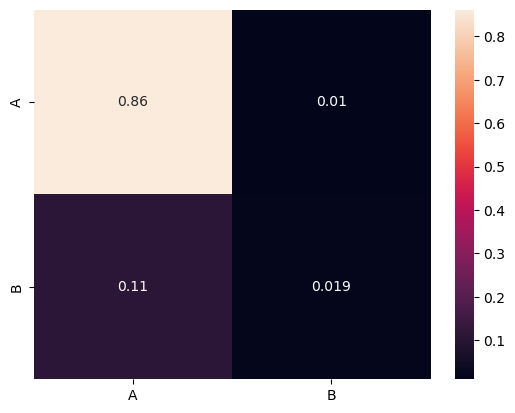

In [27]:
cf_matrix = confusion_matrix(y_test, predictions, normalize='all')
sns.heatmap(cf_matrix, annot=True, xticklabels=["A", "B"], yticklabels=["A", "B"])

Even though our accuracy seems good, our model is working with an imbalanced dataset (too many A for not many B), so it is guessing most as "A".

In [29]:
# Quick intro to data balancing:
! pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)



[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
from imblearn.over_sampling import RandomOverSampler # remember the DOCS: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html

sampler = RandomOverSampler(random_state=42)

# only sample the training data (you don't want to test on repeated or made up rows):
X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train) 

y_train_balanced.value_counts()

A    51636
B    51636
Name: status, dtype: int64

In [33]:
classification = LogisticRegression(random_state=42) #, max_iter=1000
classification.fit(X_train_balanced, y_train_balanced)
classification.score(X_test, y_test)

0.6979089625495865

<Axes: >

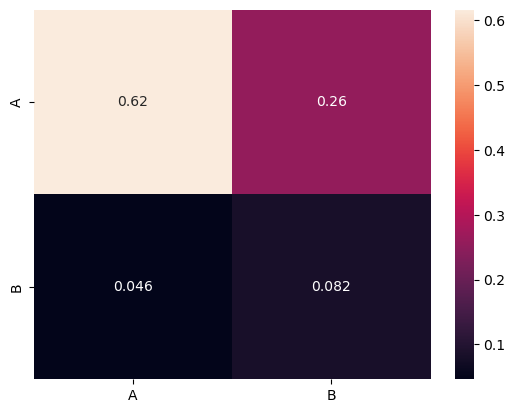

In [35]:
predictions = classification.predict(X_test)
cf_matrix = confusion_matrix(y_test, predictions, normalize='all')
sns.heatmap(cf_matrix, annot=True, xticklabels=["A", "B"], yticklabels=["A", "B"])

We see now that there was a trade off between the metrics. Now "A" is being predited less times and "B" is being predicted slightly better.

##### Next Steps:
1. Scale the data;
2. Try balancing scaling techniques;
4. Try different classification algorithms;
5. Try to get more data from other tables that might help predit a default on the loans;
6. Engineer the problem differently.

![](https://media.makeameme.org/created/documentation-for-the.jpg)